In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.utils import class_weight

# Suppress non-critical warnings for a cleaner output
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# --- Define the correct data directory for your Kaggle environment ---
# This path assumes the dataset is linked to your notebook.
DATA_DIR = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
CATEGORIES = ['no', 'yes']

# Define fixed parameters
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

2025-11-05 07:06:08.978112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762326369.224348      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762326369.296408      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Image counts per category: {'no': 98, 'yes': 155}
Total images: 253


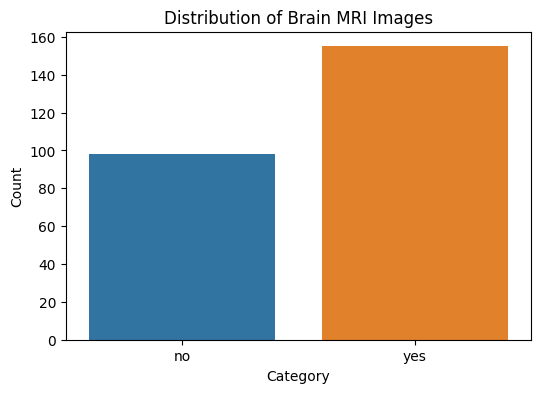

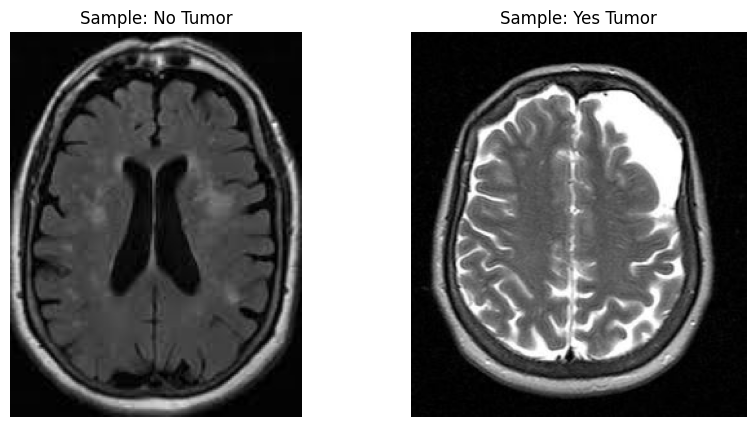

In [2]:
# Count images in each category
image_counts = {} 
for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    image_counts[category] = len(os.listdir(path))

print("Image counts per category:", image_counts)
print(f"Total images: {sum(image_counts.values())}")

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Distribution of Brain MRI Images')
plt.xlabel('Category')
plt.ylabel('Count')
plt.savefig('distribution_barplot.png')
plt.show()

# Visualize sample images
plt.figure(figsize=(10, 5))
for i, category in enumerate(CATEGORIES):
    path = os.path.join(DATA_DIR, category)
    # Ensure there's at least one file before attempting to access the first element
    if os.listdir(path):
        img_path = os.path.join(path, os.listdir(path)[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(f'Sample: {category.capitalize()} Tumor')
        plt.axis('off')
plt.savefig('sample_images.png')
plt.show()

In [3]:
# Using ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    validation_split=0.2,       # Set aside 20% of data for validation
    rotation_range=15,          # Randomly rotate images
    width_shift_range=0.1,      # Randomly shift images horizontally
    height_shift_range=0.1,     # Randomly shift images vertically
    shear_range=0.1,            # Apply shear transformations
    zoom_range=0.1,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'
)

# Create data generators from the directory 
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Specify this is the training set
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # Specify this is the validation set
    shuffle=False
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [14]:
## 🧠 Step 3: Start Simple - Non-Deep Learning Baseline
# This establishes the performance floor for the CNN to beat.

print("--- Starting Simple Baseline Model (Logistic Regression) ---")

# --- Function to Load and Preprocess Raw Image Data ---
def load_raw_data(data_dir, img_size):
    X = [] 
    y = []
    class_indices = {'no': 0, 'yes': 1}
    for category, index in class_indices.items():
        path = os.path.join(data_dir, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            # Load image and resize
            img = image.load_img(img_path, target_size=img_size)
            # Convert to numpy array and normalize (0-1)
            img_array = image.img_to_array(img) / 255.0
            
            # Flatten to a 1D feature vector for Logistic Regression
            X.append(img_array.flatten()) 
            y.append(index)
    
    return np.array(X), np.array(y)

# Load data (using the same size as CNN input)
X_data, y_data = load_raw_data(DATA_DIR, IMG_SIZE)

# Split data (using a stratify split to maintain class ratio in validation set)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
) 

# Initialize and train the Logistic Regression model
# Increased max_iter for convergence on large feature space
baseline_model = LogisticRegression(max_iter=1000) 
baseline_model.fit(X_train_base, y_train_base)

# Evaluate on the validation set
y_pred_base = baseline_model.predict(X_val_base)
baseline_accuracy = accuracy_score(y_val_base, y_pred_base)

print(f"Logistic Regression Baseline Accuracy: {baseline_accuracy:.4f}")
print("--- Simple Baseline Complete ---")

--- Starting Simple Baseline Model (Logistic Regression) ---
Logistic Regression Baseline Accuracy: 0.7647
--- Simple Baseline Complete ---


In [15]:
## ⚖️ Step 4: Data Quality - Calculate and Apply Class Weights
# This addresses the data imbalance for deep learning models.

# The generator must be reset before getting class indices/labels
train_generator.reset() 

# Get the class indices for all samples in the training set
class_labels = train_generator.classes

# Calculate balanced weights
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels 
)

# Convert to a dictionary format required by Keras (e.g., {0: 1.28, 1: 0.81})
class_weights_dict = dict(enumerate(class_weights_array))

print(f"Calculated Class Weights: {class_weights_dict}")

# --- Define Callbacks for CNN and EfficientNet ---
# Stop training if validation loss doesn't improve for 5 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Reduce the learning rate if the training performance plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

Calculated Class Weights: {0: 1.2848101265822784, 1: 0.8185483870967742}


In [16]:
# --- 1. Build the CNN Model ---
custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# --- 2. Compile the Model ---
custom_cnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

custom_cnn.summary()

print("--- Starting Custom CNN Training (WITH CLASS WEIGHTS) ---")
# --- 3. Train the Model (MODIFIED to use class_weight_dict) ---
history_cnn = custom_cnn.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    # CLASS WEIGHTS APPLIED HERE
    class_weight=class_weights_dict 
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

--- Starting Custom CNN Training (WITH CLASS WEIGHTS) ---
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5200 - loss: 1.1059 - val_accuracy: 0.6200 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6495 - loss: 0.6100 - val_accuracy: 0.7600 - val_loss: 0.5947 - learning_rate: 0.0010
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6753 - loss: 0.6243 - val_accuracy: 0.7400 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8104 - loss: 0.4916 - val_accuracy: 0.7600 - val_loss: 0.5018 - learning_rate: 0.0010
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7562 - loss: 0.5506 - val_accuracy: 0.7000 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6895 - loss: 0.6128 - val_accuracy: 0.7200 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# --- SETUP THE MODEL ---
# NOTE: Update the weights_path if the location changes in your Kaggle environment!
weights_path = '../input/efficientnetb0b7-keras-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'

# Load weights in two steps
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3)) 
try:
    base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
except Exception as e:
    print(f"Warning: Could not load EfficientNetB0 weights from specified path. Training from scratch. Error: {e}")

# Freeze the base model initially 
base_model.trainable = False 

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# --- STAGE 1: FEATURE EXTRACTION (MODIFIED to use class_weight_dict) ---
# Compile the model for the first stage
efficientnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print("--- Starting Stage 1: Feature Extraction (WITH CLASS WEIGHTS) ---")
# Train only the top layers
history_effnet = efficientnet_model.fit(
    train_generator,
    epochs=25, 
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    # CLASS WEIGHTS APPLIED HERE
    class_weight=class_weights_dict
)

# --- STAGE 2: FINE-TUNING (MODIFIED to use class_weight_dict) ---
print("\n--- Starting Stage 2: Fine-Tuning (WITH CLASS WEIGHTS) ---")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Unfreeze the top 30 layers of EfficientNetB0
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile the model with a very low learning rate.
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training the model (fine-tuning) 
history_fine_tune = efficientnet_model.fit(
    train_generator,
    epochs=history_effnet.epoch[-1] + 10,  # Train for 10 more epochs 
    initial_epoch=history_effnet.epoch[-1],
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    # CLASS WEIGHTS APPLIED HERE
    class_weight=class_weights_dict 
)

--- Starting Stage 1: Feature Extraction (WITH CLASS WEIGHTS) ---
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.4639 - loss: 0.7145 - val_accuracy: 0.3800 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4807 - loss: 0.6878 - val_accuracy: 0.6200 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5925 - loss: 0.6912 - val_accuracy: 0.6200 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4582 - loss: 0.7225 - val_accuracy: 0.3800 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4102 - loss: 0.6968
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4162 - loss: 0.6977 - val_accuracy: 0.6200 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


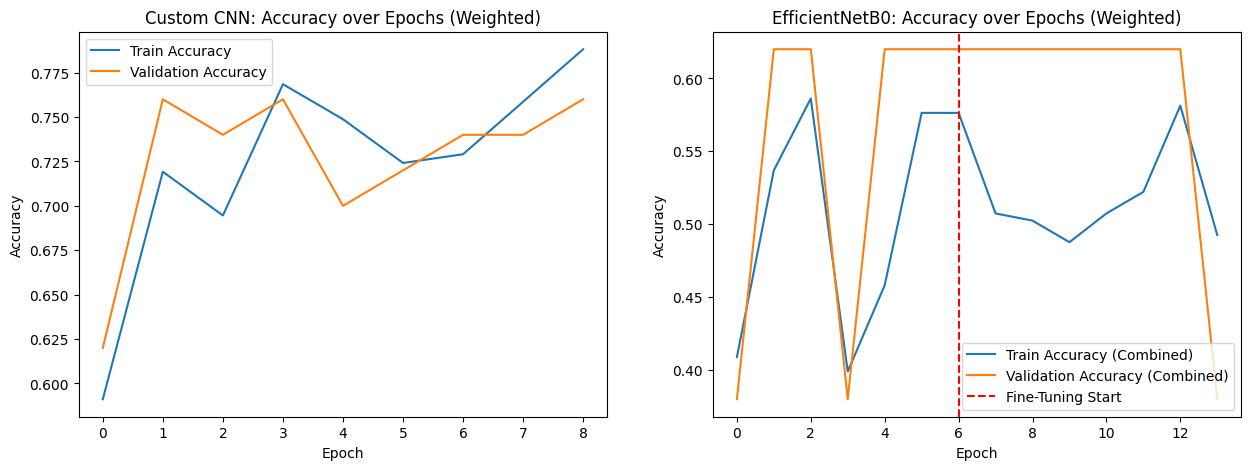

--- Classification Report for Custom CNN (Weighted) ---
              precision    recall  f1-score   support

          no       0.69      0.47      0.56        19
         yes       0.73      0.87      0.79        31

    accuracy                           0.72        50
   macro avg       0.71      0.67      0.68        50
weighted avg       0.72      0.72      0.71        50


--- Classification Report for EfficientNetB0 (Weighted) ---
              precision    recall  f1-score   support

          no       0.00      0.00      0.00        19
         yes       0.62      1.00      0.77        31

    accuracy                           0.62        50
   macro avg       0.31      0.50      0.38        50
weighted avg       0.38      0.62      0.47        50



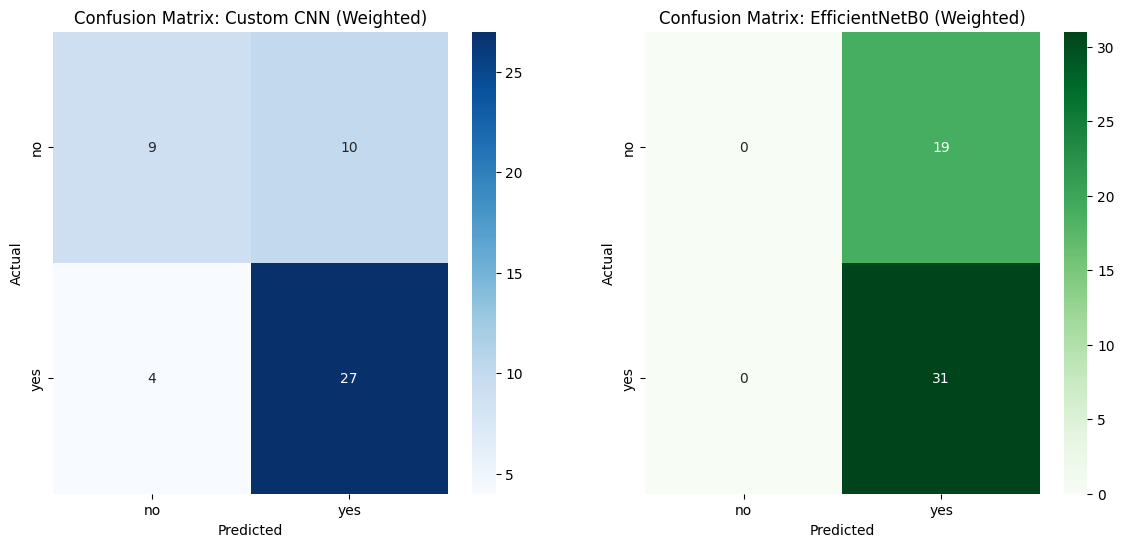

In [20]:
# --- Evaluation ---
# Reset validation generator to ensure predictions match true labels order
validation_generator.reset()

# Get predictions from both models
y_true = validation_generator.classes  
y_pred_cnn_prob = custom_cnn.predict(validation_generator)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

y_pred_effnet_prob = efficientnet_model.predict(validation_generator)
y_pred_effnet = (y_pred_effnet_prob > 0.5).astype(int).flatten()

# Get class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# --- Plotting Training History ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# CNN History
ax[0].plot(history_cnn.history['accuracy'], label='Train Accuracy')
ax[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Custom CNN: Accuracy over Epochs (Weighted)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend() 

# EfficientNet History (Combine Stage 1 and Stage 2)
# Determine the length of the combined history for plotting x-axis
total_epochs = len(history_effnet.history['accuracy']) + len(history_fine_tune.history['accuracy'])
combined_acc = history_effnet.history['accuracy'] + history_fine_tune.history['accuracy']
combined_val_acc = history_effnet.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
epochs_range = range(len(combined_acc))

ax[1].plot(epochs_range, combined_acc, label='Train Accuracy (Combined)')
ax[1].plot(epochs_range, combined_val_acc, label='Validation Accuracy (Combined)')
ax[1].axvline(x=len(history_effnet.history['accuracy']) - 1, color='r', linestyle='--', label='Fine-Tuning Start')
ax[1].set_title('EfficientNetB0: Accuracy over Epochs (Weighted)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.savefig('cnn_effnet_accuracy_history.png')
plt.show()

# --- Classification Reports ---
print("--- Classification Report for Custom CNN (Weighted) ---")
print(classification_report(y_true, y_pred_cnn, target_names=class_labels))

print("\n--- Classification Report for EfficientNetB0 (Weighted) ---")
print(classification_report(y_true, y_pred_effnet, target_names=class_labels))

# --- Confusion Matrices ---
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_effnet = confusion_matrix(y_true, y_pred_effnet)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax[0])
ax[0].set_title('Confusion Matrix: Custom CNN (Weighted)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_effnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=ax[1])
ax[1].set_title('Confusion Matrix: EfficientNetB0 (Weighted)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.savefig('confusion_matrices_weighted.png')
plt.show()

In [ ]:
Clinical Implications: 

Prioritize Urgent Cases: Helps radiologists identify and review potentially positive scans faster.

Reduce Diagnostic Errors: Acts as a "second pair of eyes" to increase accuracy and confidence.

Improve Workflow Efficiency: Manages workload by assisting with the large volume of normal scans.